<a href="https://colab.research.google.com/github/KenObata/TISMIR_notebooks/blob/main/Music4All_dataset_extraction_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset creation

Situation: English only (=multi-class).
Split: StratifiedKfold.
Reference: https://github.com/jasonwei20/eda_nlp


### Preprocess: import files

In [ ]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.5 MB/s 


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [ ]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [ ]:
def analyze_genre_tag_df(df, target_column:int, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[target_column]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, target_column =1, top_n=top_n)

### Data preparation

id_genres.csv

Number of genres: 853


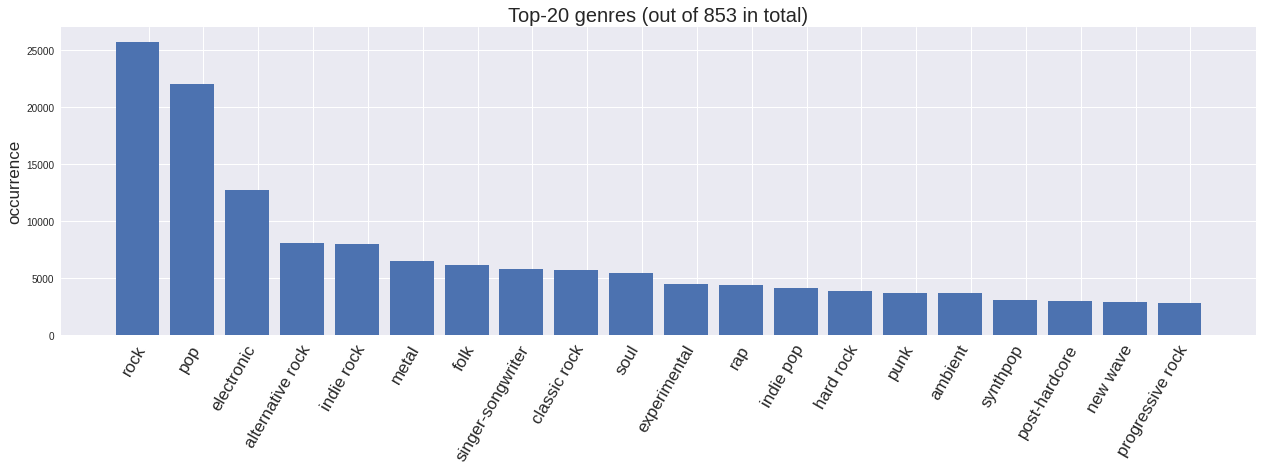

In [ ]:
genre_counter = analyze_genre_tag_csv('id_genres.csv',top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [ ]:
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top = genre_counter[:15]

In [ ]:
genre_counter_top_list = [genre for genre, count in genre_counter_top ]
genre_counter_top_list

['rock',
 'pop',
 'electronic',
 'alternative rock',
 'indie rock',
 'metal',
 'folk',
 'singer-songwriter',
 'classic rock',
 'soul',
 'experimental',
 'rap',
 'indie pop',
 'hard rock',
 'punk']

In [ ]:
#filter genre dataset as top15 genre only and later inner join with English.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(genre_counter_top_list)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

### Filter only English
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [ ]:
en_lang =['en']
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


Originally it was 109269 rows, and now there are 84103 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [ ]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


ToDo: concatenate to the dataframe!

In [ ]:
final_genre_list = ["pop", "rock", "soul", "indie rock", "rap", "electronic", "folk", "singer-songwriter", "indie pop", "punk"]
#df_lang_en=df_lang[ df_lang['lang'].isin(en_lang) ]
df_genre_by_lang = df_genre_by_lang[ df_genre_by_lang["genres"].isin(final_genre_list) ]

After inner join, we can drop the bottom 5, alternative rock, hard rock, experimental, classic rock, and metal

Reindex

In [ ]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00P2bHdWFkghmDqz,soul,en
2,00b6fV3nx5z2b8Ls,pop,en
3,013QDoTqbexEwkHr,pop,en
4,01EKNot8qVgZpKM7,rock,en
...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en
13536,zzgS4ZqyswamEWNj,pop,en
13537,zzx8CWdM7qkxKQpC,indie rock,en
13538,zzz0n04uuTUA7fNh,pop,en


### Get lyrics document as dataframe and append to X_train, X_test

In [ ]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00P2bHdWFkghmDqz,soul,en,
2,00b6fV3nx5z2b8Ls,pop,en,
3,013QDoTqbexEwkHr,pop,en,
4,01EKNot8qVgZpKM7,rock,en,
...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,
13536,zzgS4ZqyswamEWNj,pop,en,
13537,zzx8CWdM7qkxKQpC,indie rock,en,
13538,zzz0n04uuTUA7fNh,pop,en,


In [ ]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

### Create dataframe

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
text = "This is a test sentence. Yo, 123 today2022"
text= text.replace(',', '')
text = text.replace('.', '')
text_tokens = [stemmer.stem(word) for word in text.split(' ') ]
print(text_tokens)

#text_tokens_alphabet = []
#for word in text.split(' '):
#  temp_word = stemmer.stem(word)
#  print("temp:", temp_word)
#  if temp_word.isalpha():
#    text_tokens_alphabet.append(temp_word)
text_tokens_alphabet = [stemmer.stem(word) for word in text.split(' ') if word.isalpha()]
print(text_tokens_alphabet)

['thi', 'is', 'a', 'test', 'sentenc', 'yo', '123', 'today2022']
['thi', 'is', 'a', 'test', 'sentenc', 'yo']


This study removes "," and "." to get only alphabets.

In [ ]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

df_genre_by_lang['number_of_line'] = 0
#df_genre_by_lang['text_split'] = []
for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [word for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]
      
      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#index 5001 ~ 7988
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:df_genre_by_lang.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read()
      number_of_line = lyric_document.count('\n')

      lyric_document = lyric_document.replace('\n', ' ').replace(',', '').replace('.', '')
      lyric_document.lower()
      text_split = [word for word in lyric_document.split(' ') if word.isalpha() ]
      lyric_document=[' '.join(text_split) ]

      #df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "text_split"] =text_split
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "number_of_line"] = number_of_line
      #print(lyric_document)

  except Exception as e:
    print(e)


In [ ]:
#Reindex again
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)

In [ ]:
df_genre_by_lang[0:df_genre_by_lang.shape[0]]

,id,genres,lang,lyric,number_of_line
0,0009fFIM1eYThaPg,pop,en,a sunny day so I got nowhere to hide Not a clo...,91
1,00P2bHdWFkghmDqz,soul,en,Tell me a tale that always was Sing me a song ...,36
2,00b6fV3nx5z2b8Ls,pop,en,A buh A buh You went to school to learn girl T...,74
3,013QDoTqbexEwkHr,pop,en,like a conversation where stops to breathe Is ...,20
4,01EKNot8qVgZpKM7,rock,en,Say the words I cannot say Say them on another...,31
...,...,...,...,...,...
13535,zzT504Z94j1IAuc3,indie rock,en,think what afraid of come in you know been mad...,18
13536,zzgS4ZqyswamEWNj,pop,en,Oh yeah yeah Last night I took a walk in the s...,75
13537,zzx8CWdM7qkxKQpC,indie rock,en,Innocence it come easy in a sense it never wil...,34
13538,zzz0n04uuTUA7fNh,pop,en,Girl you know how I feel I really Since you be...,65


In [ ]:
df_genre_by_lang.shape[0]

13540

### Data Preparation(Kfold split)

Create dataframe for Gensim

In [ ]:
def load_data(df_col, y):
    texts, labels = [], []
    
    for line in df_col:
        # texts are already tokenized, just split on space
        # in a real use-case we would put more effort in preprocessing
        texts.append(line.split(' '))
    return pd.DataFrame({'texts': texts, 'labels': y})

In [ ]:
data = load_data(df_genre_by_lang["lyric"], df_genre_by_lang["genres"])

In [ ]:
data

,texts,labels
0,"[a, sunny, day, so, I, got, nowhere, to, hide,...",pop
1,"[Tell, me, a, tale, that, always, was, Sing, m...",soul
2,"[A, buh, A, buh, You, went, to, school, to, le...",pop
3,"[like, a, conversation, where, stops, to, brea...",pop
4,"[Say, the, words, I, cannot, say, Say, them, o...",rock
...,...,...
13535,"[think, what, afraid, of, come, in, you, know,...",indie rock
13536,"[Oh, yeah, yeah, Last, night, I, took, a, walk...",pop
13537,"[Innocence, it, come, easy, in, a, sense, it, ...",indie rock
13538,"[Girl, you, know, how, I, feel, I, really, Sin...",pop


In [ ]:
data['labels'] = data['labels'].astype('category')
label_mapping = data['labels'].cat.categories
data['labels'] = data['labels'].cat.codes
X = data['texts']
y = data['labels']

In [ ]:
type(X)

pandas.core.series.Series

In [ ]:
def StratifiedKFold_feature_and_df_glove(df, feature_list, y_name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  y = df[y_name]
  skf.get_n_splits(df[ feature_list ], y)

  splits = []

  for train_index, test_index in skf.split(df[ feature_list ], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[ feature_list ].loc[train_index], df[ feature_list ].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
def StratifiedKFold_feature_and_df(X, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1209)  # 20% for test set 
  #y = df[y_name]
  skf.get_n_splits(X, y)#df[ feature_list ]

  splits = []

  for train_index, test_index in skf.split(X, y):#df[ feature_list ]
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [ ]:
#feature_list = ["texts"] #this is BOW and TF-IDF
#splits = StratifiedKFold_feature_and_df( data, feature_list, 'labels')
splits = StratifiedKFold_feature_and_df( X,y)

TRAIN: [    0     1     3 ... 13537 13538 13539] TEST: [    2     4     5 ... 13526 13532 13535]
TRAIN: [    0     2     4 ... 13535 13536 13539] TEST: [    1     3     7 ... 13530 13537 13538]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [    8    14    22 ... 13521 13531 13536]
TRAIN: [    0     1     2 ... 13537 13538 13539] TEST: [   10    12    15 ... 13523 13525 13534]
TRAIN: [    1     2     3 ... 13536 13537 13538] TEST: [    0     6    11 ... 13529 13533 13539]


In [ ]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)
print(split0['X_test'].shape)
print(split0['y_test'].shape)

(10832,)
(10832,)
(2708,)
(2708,)


In [ ]:
split0['X_train']

0        [a, sunny, day, so, I, got, nowhere, to, hide,...
1        [Tell, me, a, tale, that, always, was, Sing, m...
3        [like, a, conversation, where, stops, to, brea...
6        [Locked, up, tight, Like, I, would, never, fee...
7        [sittin, in, the, crib, dreamin, about, leer, ...
                               ...                        
13534    [grandma, cookies, nigga, Shout, out, to, fron...
13536    [Oh, yeah, yeah, Last, night, I, took, a, walk...
13537    [Innocence, it, come, easy, in, a, sense, it, ...
13538    [Girl, you, know, how, I, feel, I, really, Sin...
13539    [wwI, oh, must, go, on, standing, You, break, ...
Name: texts, Length: 10832, dtype: object

In [ ]:
split0['y_train']

0        4
1        9
3        4
6        4
7        6
        ..
13534    6
13536    4
13537    3
13538    4
13539    8
Name: labels, Length: 10832, dtype: int8

### Gensim tutorial (count total vocab)
We start off by using the Gensim's implementation of the algorithm to provide a high-level intuition

In [ ]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
#%load_ext watermark
#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
from time import time
from joblib import cpu_count
from collections import Counter
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups

#%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,gensim

In [ ]:
#1.get tokens
#sentences = [doc.strip().split() for doc in df_genre_by_lang["lyric"]]
sentences = [ doc.strip().split() for doc in split0['X_train'] ]

workers = cpu_count()
word2vec = Word2Vec(sentences, workers=workers)

word_vectors = pd.DataFrame(word2vec.wv.vectors, index=word2vec.wv.index2word)

print('word vector dimension: ', word_vectors.shape)
word_vectors.head()

AttributeError: ignored

In [ ]:
print("sentences:", sentences[0])

Note to myself: how to change dimensionality and how much does it matter?
The lack of experiments for embedding size implies that the performance is not very sensitive to this parameter. But the number of dimensions can affect training time.

https://datascience.stackexchange.com/questions/51404/word2vec-how-to-choose-the-embedding-size-parameter


In [ ]:
word2vec.wv.most_similar(positive=['love'], topn=5)

There is a window size hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).

In [ ]:
word2vec.corpus_total_words

In [ ]:
vocab = word2vec.wv.vocab
index2word = word2vec.wv.index2word
print("vocaburary size:",len(vocab))
print(len(index2word))

In [ ]:
pd.set_option('display.max_rows', word_vectors.shape[1]+1)
word_vectors

### (Part1) Gensim Implementation

Parameter

sg=1 means to use skip-gram

min_count... is a threashhold that the algorithm requires a word need to appear at least x time ot be considered as part of skip-gram algorithm.

size... is the # of dimensions.

iterations ... ?


In [ ]:
!pip3 install transformers #==4.11.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.0 MB/s 
     |████████████████████████████████| 596 kB 77.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Ref:https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights
Ref:https://gist.github.com/AbhishekAshokDubey/054af6f92d67d5ef8300fac58f59fcc9


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec, Phrases, phrases, KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """
    
    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)

        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

100 dim

### Visualize original lyrics document (X_embeddings_temp) via Glove weight matrix

In [ ]:
del(df_word_vector3)

In [ ]:
print(X_embeddings_temp.shape, split0['y_train'].shape)

(10832, 100) (10832,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector3 = pd.DataFrame(X_embeddings_temp)

In [ ]:
df_word_vector3.shape

(10832, 100)

In [ ]:
type(split0['y_train'])

pandas.core.series.Series

In [ ]:
df_word_vector3['y'] = -1
print(df_word_vector3.shape)

(10832, 101)


In [ ]:
for i, (_, genre_code) in enumerate(split0['y_train'].items()):
  #print(i, genre_code)
  df_word_vector3.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector3.shape

(10832, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca3 = PCA(n_components=3)
pca_result3 = pca3.fit_transform(df_word_vector3[feature_cols].values)

df_word_vector3['pca-one'] = pca_result3[:,0]
df_word_vector3['pca-two'] = pca_result3[:,1] 
df_word_vector3['pca-three'] = pca_result3[:,2]

print('Explained variation per principal component: {}'.format(pca3.explained_variance_ratio_))

Explained variation per principal component: [0.08235912 0.0571936  0.04286555]


In [ ]:
number_of_y = len(set(df_word_vector3["y"]))
number_of_y

10

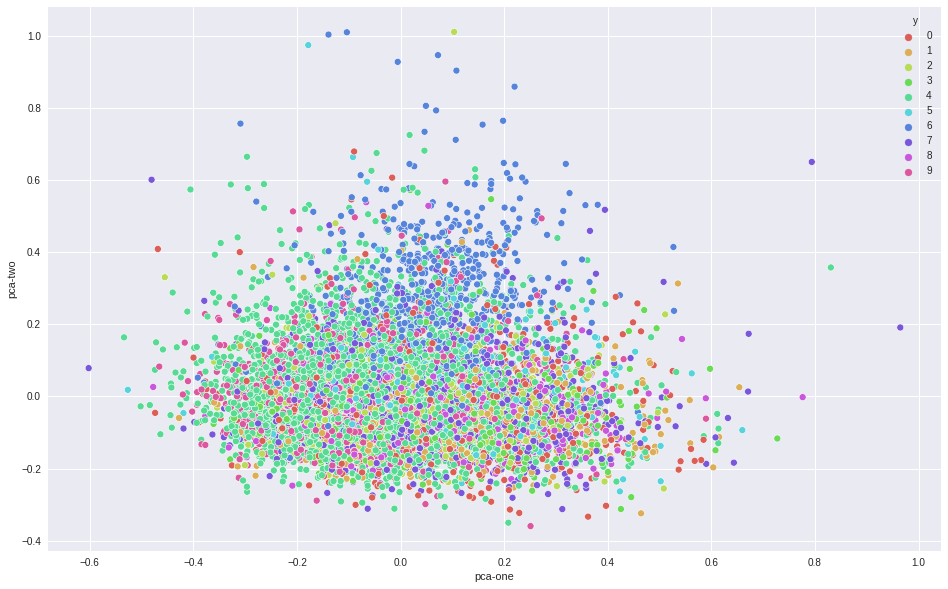

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector3.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector3.loc[rndperm,:],
    legend="full",
    alpha=1
)

### Visualize original data after SMOTE

In [ ]:
print(X_resampled_temp.shape, y_resampled_temp.shape)#X_resampled_temp, y_resampled_temp

(41430, 100) (41430,)


In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_word_vector4 = pd.DataFrame(X_resampled_temp)

In [ ]:
df_word_vector4.shape

(41430, 100)

In [ ]:
type(y_resampled_temp)

pandas.core.series.Series

In [ ]:
df_word_vector4['y'] = -1
print(df_word_vector4.shape)

(41430, 101)


In [ ]:
for i, (_, genre_code) in enumerate(y_resampled_temp.items()):
  #print(i, genre_code)
  df_word_vector4.loc[i, 'y'] = genre_code

In [ ]:
df_word_vector4.shape

(41430, 101)

In [ ]:
feature_cols = [ num for num in range(0,100)]
pca4 = PCA(n_components=3)
pca_result4 = pca4.fit_transform(df_word_vector4[feature_cols].values)

df_word_vector4['pca-one'] = pca_result4[:,0]
df_word_vector4['pca-two'] = pca_result4[:,1] 
df_word_vector4['pca-three'] = pca_result4[:,2]

print('Explained variation per principal component: {}'.format(pca4.explained_variance_ratio_))

Explained variation per principal component: [0.10478059 0.07526815 0.04039155]


In [ ]:
number_of_y = len(set(df_word_vector4["y"]))
number_of_y

10

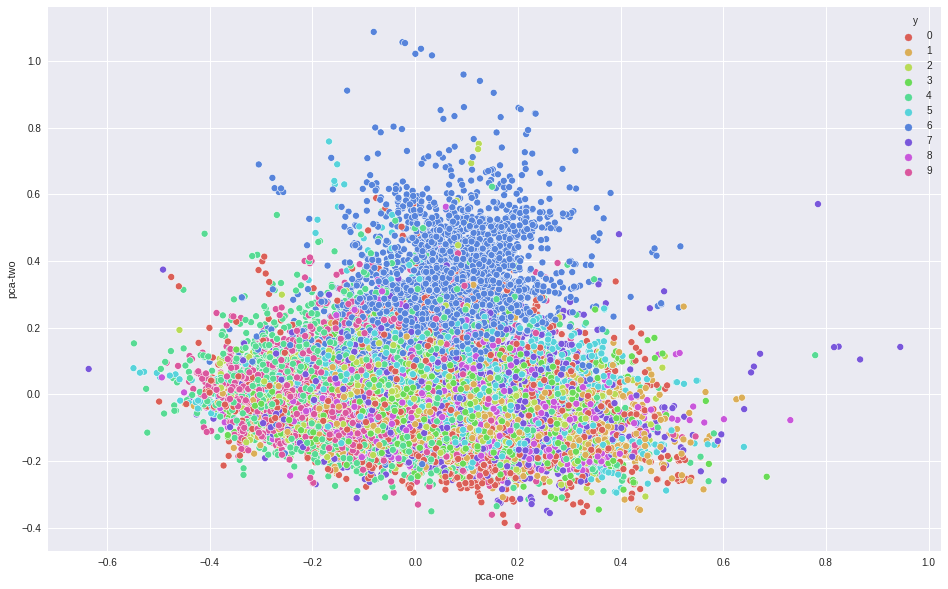

In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df_word_vector4.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", number_of_y),
    data=df_word_vector4.loc[rndperm,:],
    legend="full",
    alpha=1
)